In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from pathos.multiprocessing import ProcessingPool
from config import *
from utility import *

In [2]:
from multiprocessing import Pool
pool = ProcessingPool(8)

Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bzr0014/envs/AI/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bzr0014/envs/AI/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bzr0014/envs/AI/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bzr0014/envs/AI/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/bzr0014/envs/AI/lib/python3.5/site-packages/multiprocess/process.py

In [3]:
low_bin_3d = load('part_analysis_result/area_April26_AMboneA1_volume.pkl')
darkfield = np.array(h5py.File('files/%s_darkfield.h5'%H5NAMES[0])['darkfield'])
absorption = np.array(h5py.File('files/%s_abs.h5'%H5NAMES[0])['absorption'])
#area1 = load('part_analysis_result/area_April27_AMA2_volume.pkl')

In [4]:
files = sorted(glob('LSU_NonHIP/2.9um/*tiff'))

In [5]:
high_bin_3d = np.array([cv2.imread(file, 0) for file in sorted(glob('part_analysis_result/lsu_dogbonenonhip_2.9um/*png'))])

In [6]:
high_rotated_rects = list(map(get_rotated_rect, high_bin_3d))

In [7]:
angles = np.array([x[-1] for x in high_rotated_rects])

In [8]:
from scipy.stats import mode
angle_mode = mode(angles.round(1))
print(angle_mode.mode)
print(np.mean(angles.round(1)))
print(np.median(angles.round(1)))

[-85.6]
-85.38856569709127
-85.4


In [9]:
def rotate_image(img, angle):
    #get center
    center = tuple(x//2 for x in img.shape)
    # get row and col num in img
    height, width = img.shape[0], img.shape[1]
    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))
    # now rotated rectangle becomes vertical and we crop it
    return img_rot

In [10]:
high_rotated_bin = np.array([rotate_image(_, -85.6) for _ in high_bin_3d])
high_rotated_bin.shape

(997, 1009, 988)

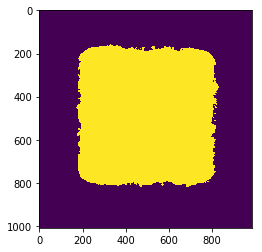

In [11]:
plt.imshow(high_rotated_bin[500])

In [12]:
high_side1 = np.mean(high_rotated_bin, axis=1)
high_side2 = np.mean(high_rotated_bin, axis=2)

In [13]:
print(high_rotated_bin.shape)
print(high_side1.shape)

(997, 1009, 988)
(997, 988)


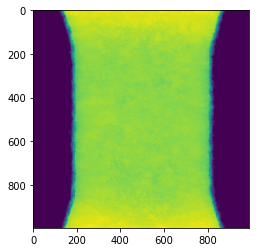

In [14]:
plt.imshow(high_side1)

In [15]:
low_rotated_rect = [get_rotated_rect(_) for _ in low_bin_3d['absorption']]

In [16]:
print(mode(np.round([x[-1] for x in low_rotated_rect], 1)))
print(np.mean(np.round([x[-1] for x in low_rotated_rect], 1)))
print(np.median(np.round([x[-1] for x in low_rotated_rect], 1)))

ModeResult(mode=array([-82.9]), count=array([29]))
-82.45360000000001
-82.5


In [17]:
def tmp(x):
    x = (x == x[350, 300]).astype('uint8')
    return rotate_image(x, -82.9)
low_rotated_bin = np.array([tmp(_) for _ in low_bin_3d['absorption']])#[:,200:400,200:350]

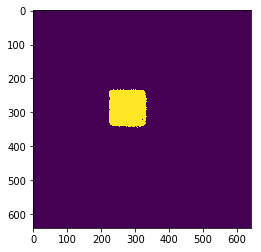

In [18]:
plt.imshow(low_rotated_bin[100])

In [19]:
low_side1 = np.mean(low_rotated_bin, axis=1)
low_side2 = np.mean(low_rotated_bin, axis=2)

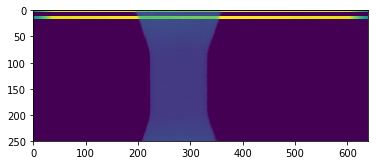

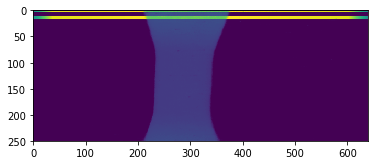

In [20]:
plt.imshow(low_side1)
plt.show()
plt.imshow(low_side2)

In [21]:
from sklearn.cluster import KMeans
def get_edges(x):
    model1 = KMeans(n_clusters=2, n_jobs=8)
    model1.fit(x.reshape(-1, 1))
    tmp = model1.predict(x.reshape(-1, 1)).reshape(*x.shape)
    tmp = tmp == tmp[tuple(x//2 for x in tmp.shape)]
    indices = get_largest_contour(tmp)[:,0,0].reshape(-1,1)
    model2 = KMeans(n_clusters=2, n_jobs=8)
    model2.fit(indices)
    return model2.cluster_centers_, np.abs(model2.cluster_centers_[1]-model2.cluster_centers_[0])[0], tmp

In [22]:
(h_c1, hl1, hside1), (h_c2, hl2, hside2) = get_edges(high_side1[200:800]), get_edges(high_side2[200:800])

In [23]:
(l_c1, ll1, lside1), (l_c2, ll2, lside2) = get_edges(low_side1[75:-55]), get_edges(low_side2[75:-55])

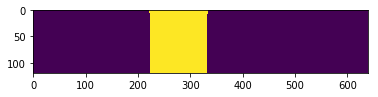

In [24]:
plt.imshow(lside1)

In [25]:
def min_max_scale(x):
    x = x *1
    return (x-x.min())/(x.max()-x.min())

In [26]:
low_side1 = min_max_scale(low_side1)>0.1
low_side2 = min_max_scale(low_side2)>0.1

new_shape = (172, 170)


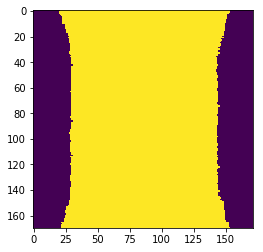

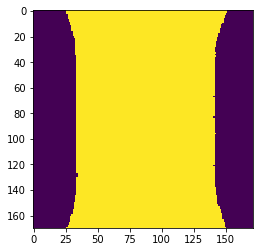

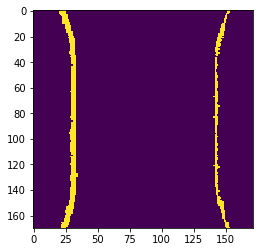

In [27]:
def visualize_align(h_side, l_side, widths, ws, hs):
    h_width, l_width = widths
    new_shape = tuple(int(np.round(x*l_width/h_width, 1)) for x in h_side.shape)
    print("new_shape = %r"%(new_shape,))
    h_resized = cv2.resize((h_side*255).astype('uint8'), new_shape)>0
    plt.imshow(h_resized)
    plt.show()

    h, w = h_resized.shape
    l_side = l_side[hs:hs+h,ws:ws+w]
    h_side = min_max_scale(h_resized)>0
    plt.imshow(l_side)
    plt.show()   
    if l_side.shape == h_resized.shape:
        plt.imshow(l_side != h_side) 
        plt.show()
    #    plt.imshow((h_resized)) 
    #    plt.show()
    #    plt.imshow((l_side)) 
    #    plt.show()
    else:
        print("Sizes don't match")
visualize_align(high_side1, low_side1, (hl1, ll1), 190, 55)
#visualize_align(high_side2, rotate_image(low_side2.astype('uint8'), 2), (hl2, ll2), 197, 50)
#_(high_side1, rotate_image(low_side2, 2), hl2, ll2, 200, 55)

In [32]:
def align(args):
    h_side, l_side, widths, ws, hs = args
    h_width, l_width = widths
    new_shape = tuple(int(np.round(x*l_width/h_width, 1)) for x in h_side.shape)
    h_resized = (cv2.resize(h_side*255, new_shape)>0)
    h, w = h_resized.shape
    l_side = (l_side[hs:hs+h,ws:ws+w] > 0)
    print(h_resized.shape, l_side.shape)
    if l_side.shape == h_resized.shape:
        return np.sum(l_side != h_resized)
    return float('inf')

ins = lambda : ((high_side1, low_side1, (hl, ll), x, y)
         for hl in np.arange(hl1-5, hl1+5)
         for ll in np.arange(ll1-5, ll1+5)
         for x in range(190,210)
         for y in range(40, 60))

In [33]:
abbas = pool.map(align, ins())

In [35]:
h_side, l_side, widths, ws, hs =list(ins())[np.argmin(abbas)]
print(widths, ws, hs)

(628.5692277859175, 103.34271099744245) 195 57


new_shape = (163, 162)


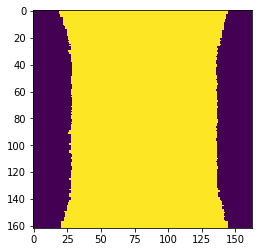

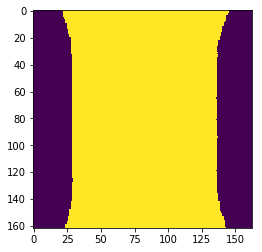

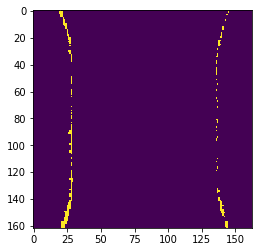

In [36]:
visualize_align(h_side, l_side, widths, ws, hs)

In [37]:
(widths, ws, hs)

((628.5692277859175, 103.34271099744245), 195, 57)

# side 2

In [38]:
tmp = rotate_image(low_side2.astype('uint8'), 2)
ins2 = lambda : ((high_side2, tmp, (h2, l2), x, y)
         for h2 in np.arange(hl2-5, hl2+5)
         for l2 in np.arange(ll2-5, ll2+5)
         for x in range(190,210)
         for y in range(40, 60))

In [39]:
abbas2 = pool.map(align, ins2())

In [40]:
h_side2, l_side2, widths2, ws2, hs2 =list(ins2())[np.argmin(abbas2)]
print(widths2, ws2, hs2)

(620.2715981888782, 102.60000000000002) 200 54


new_shape = (164, 166)


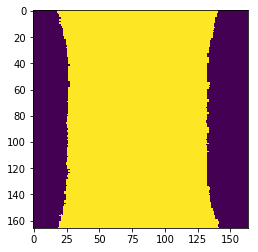

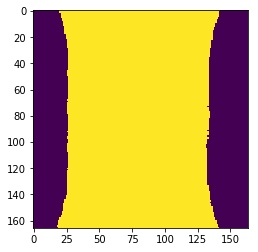

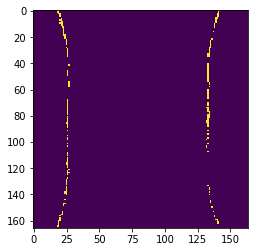

new_shape = (163, 162)


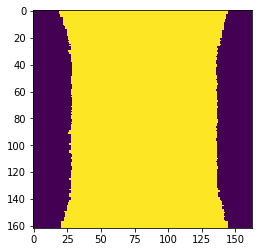

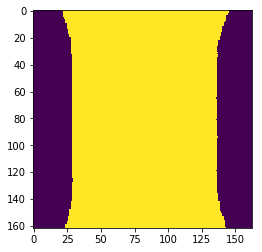

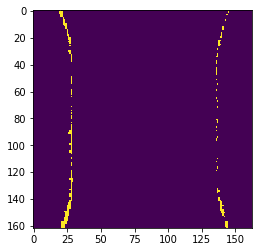

In [41]:
visualize_align(h_side2, l_side2, widths2, ws2, hs2)
visualize_align(h_side, l_side, widths, ws, hs)

In [8]:
shape2 = (164, 166)
shape = (163, 162)

In [9]:
h_rotate_angle, l_rotate_angle = -85.6, -82.9
widths2, ws2, hs2 = (620.2716, 102.6), 200, 54
widths, ws, hs = (628.5692, 103.3427), 195, 57
print(h_rotate_angle, l_rotate_angle)
print(widths2, ws2, hs2, shape2)
print(widths, ws, hs, shape)

-85.6 -82.9
(620.2716, 102.6) 200 54 (164, 166)
(628.5692, 103.3427) 195 57 (163, 162)


In [4]:
from joblib import dump, load
high_3d = load('files/high_3d.np')#np.array([rotate_image(cv2.imread(file, 0), h_rotate_angle) for file in files])

In [5]:
#low_3d = np.array([rotate_image(x, l_rotate_angle) for x in absorption])
#dump(low_3d_tmp, 'files/low_3d.np')
low_3d = load('files/low_3d.np')

In [6]:
#low_3d_dark = np.array([rotate_image(x, l_rotate_angle) for x in darkfield])
#low_3d_dark = np.array([rotate_image(x, 2) for x in low_3d_dark.transpose([2, 0, 1])]).transpose([1, 2, 0])
#dump(low_3d_dark, 'files/low_3d_dark.np')
low_3d_dark = load('files/low_3d_dark.np')

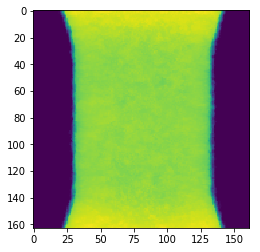

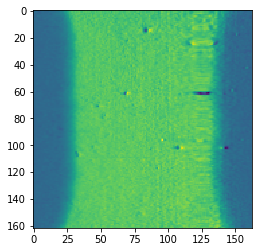

In [48]:
def transform(args):
    h_side, l_side, shape, ws, hs = args
    h_side = (min_max_scale(h_side)*255).astype('uint8')
    plt.imshow(h_side)
    plt.show()
    h_resized = (cv2.resize(h_side, shape))
    plt.imshow(h_resized), plt.show()
    h, w = shape
    l_side = (l_side[hs:hs+h,ws:ws+w])
    plt.imshow(l_side), plt.show()
    #print(h_resized.shape, l_side.shape)
    #if l_side.shape == h_resized.shape:
    #    return np.sum(l_side != h_resized)
    #return float('inf')
def transform_high(args):
    img, shape = args
    return cv2.resize((min_max_scale(h_side)*255).astype('uint8'), shape)

def transform_low(args):
    l_side, shape, ws, hs = args
    h, w = shape
    return l_side[hs:hs+h,ws:ws+w]

#transform((high_3d[:, :,400], absorption[:,:,300], widths, ws, hs))
#plt.imshow(high_3d[:, :, 400])
#transform((high_3d[:, 400,:], rotate_image(absorption.mean(axis=1), 2), widths, ws, hs))
#transform((high_3d[:, 400,:],  low_3d[:, 300, :], (162, 163), ws, hs))
#transform((high_3d[:, :,400],  low_3d[:, :,300], (171, 174), ws2, hs2))
plt.imshow(transform_high((high_3d[:, 400, :], (162, 163))))
plt.show()
plt.imshow(transform_low((low_3d[:, 300, :], (162, 163), ws, hs)))

In [49]:
tmp1 = np.array([transform_low((x, shape, ws, hs)) for x in low_3d.transpose([1,0,2])]).transpose([1,0,2])
tmp2 = np.array([transform_low((x, shape2, ws2, hs2)) for x in low_3d.transpose([2,0,1])]).transpose([1,2,0])

In [50]:
hs, hs2

(57, 54)

In [4]:
shape2 = (164, 166)
shape = (163, 162)

In [5]:
h_rotate_angle, l_rotate_angle = -85.6, -82.9
widths2, ws2, hs2 = (620.2716, 102.6), 200, 54
widths, ws, hs = (628.5692, 103.3427), 195, 57
print(h_rotate_angle, l_rotate_angle)
print(widths2, ws2, hs2, shape2)
print(widths, ws, hs, shape)

-85.6 -82.9
(620.2716, 102.6) 200 54 (164, 166)
(628.5692, 103.3427) 195 57 (163, 162)


In [6]:
from joblib import dump, load
high_3d = load('files/high_3d.np')#np.array([rotate_image(cv2.imread(file, 0), h_rotate_angle) for file in files])

In [7]:
#low_3d = np.array([rotate_image(x, l_rotate_angle) for x in absorption])
#dump(low_3d_tmp, 'files/low_3d.np')
low_3d = load('files/low_3d.np')

In [8]:
#low_3d_dark = np.array([rotate_image(x, l_rotate_angle) for x in darkfield])
#low_3d_dark = np.array([rotate_image(x, 2) for x in low_3d_dark.transpose([2, 0, 1])]).transpose([1, 2, 0])
#dump(low_3d_dark, 'files/low_3d_dark.np')
low_3d_dark = load('files/low_3d_dark.np')

((163, 162), (164, 166), 195, 57, 200, 54)
158 162 215 357
158 166 215 366
158 162 215 357
158 166 215 366


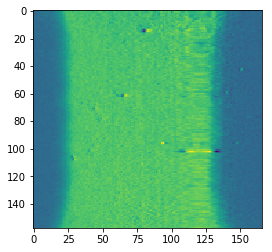

In [11]:
def transform_low_3d(args):
    l_side, shape, shape2, ws, hs, ws2, hs2= args
    h, w = shape
    h2, w2 = shape2
    print(h, w, hs+h, ws+w)
    print(h2, w2, hs2+h2, ws2+w2)
    return l_side[max(hs, hs2):min(hs+h, hs2+h2), ws:ws+w, ws2:ws2+w2]

print((shape, shape2, ws, hs, ws2, hs2))
low_transformed = transform_low_3d((low_3d, (158, 162), (158, 166), ws, hs, ws2, hs))
low_transformed_dark = transform_low_3d((low_3d_dark, (158, 162), (158, 166), ws, hs, ws2, hs))
plt.imshow(low_transformed[:,100,:])

In [12]:
low_transformed.shape

(158, 162, 166)

# Ignore Below

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from pathos.multiprocessing import ProcessingPool
from config import *
from utility import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import scipy
#scipy.ndimage.zoom?
#zoom_shape = (161, 162, 166)
factor = tuple(y/float(x) for x,y in zip(high_3d.shape, low_transformed.shape))
high_transformed = scipy.ndimage.zoom(high_3d, factor)

In [13]:
print(low_transformed.shape)
print(high_transformed.shape)

(158, 162, 166)


NameError: name 'high_transformed' is not defined

In [5]:
def binarize(x, n_clusters=2):
    model = KMeans(n_clusters=n_clusters)
    model.fit(x.reshape(-1, 1))
    res = model.predict(x.reshape(-1, 1)).reshape(*x.shape)
    return (res == res[tuple(x//2 for x in res.shape)]).astype('uint8')

In [15]:
c = binarize(high_transformed[50, :, :])
plt.imshow(c)


NameError: name 'high_transformed' is not defined

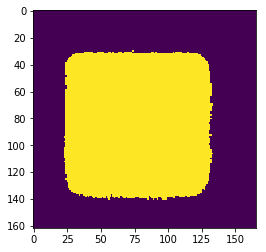

In [27]:
d = binarize(low_transformed[50, :, :])
plt.imshow(d)
#plt.show()
#plt.imshow(binarize(high_transformed.mean(axis=0)) - binarize(min_max_scale(low_transformed.mean(axis=0))))
##
##res.shape

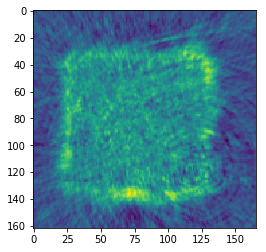

In [32]:
e = (low_transformed_dark[50, :, :])
plt.imshow(e)
#plt.show()
#plt.imshow(binarize(high_transformed.mean(axis=0)) - binarize(min_max_scale(low_transformed.mean(axis=0))))
##
##res.shape

In [3]:
from joblib import load, dump
#dump(high_transformed, 'files/high_transformed.np')
#dump(low_transformed, 'files/low_transformed.np')
#dump(low_transformed_dark, 'files/low_transformed_dark.np')
high_transformed = load('files/high_transformed.np')
low_transformed = load('files/low_transformed.np')
low_transformed_dark = load('files/low_transformed_dark.np')

In [18]:
def shift(img, p, axis):
    x = img.copy()
    if axis==0:
        if p >= 0:
            x[p:] = x[:-p]
            x[:p] = 0
        else:
            p = -p
            x[:-p] = x[p:]
            x[-p:] = 0
        return x
    elif axis==1:
        return shift(img.T, p, axis=0).T

/home/bzr0014/anaconda3/envs/tensorCpu/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


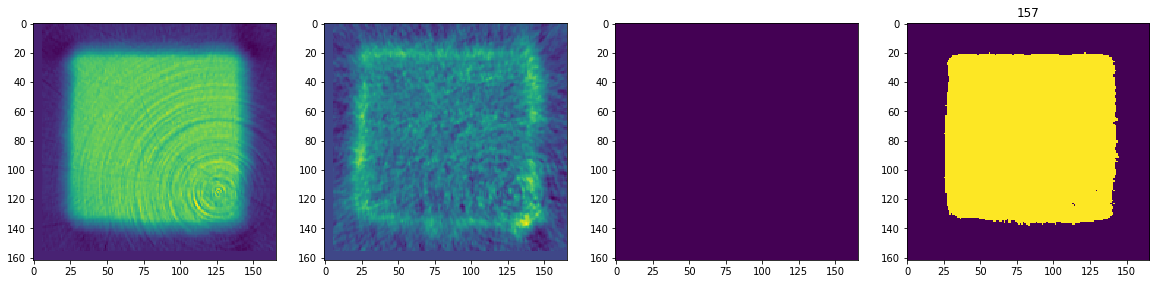

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 40
for i, images in enumerate(zip(low_transformed, low_transformed_dark, high_transformed)):
    fig, axes = plt.subplots(1,4)
    for ax, image in zip(axes[:-1], images):
        ax.imshow(image)
    #a = binarize(shift(shift(images[0], 6, axis=1), -6, axis=0) )
    a = binarize(images[0], 3)
    b = binarize(images[2],3)
    axes[-1].imshow((a==a[tuple(i//2 for i in a.shape)])*2-(b==b[tuple(i//2 for i in b.shape)]))
    plt.title(i)
    plt.show()
    clear_output(True)

In [88]:
tmp_dark = np.array([(shift(shift(image, 6, axis=1), -6, axis=0)) for image in low_transformed_dark])

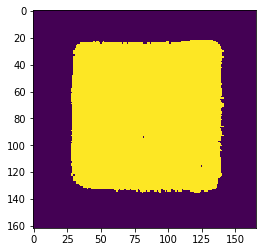

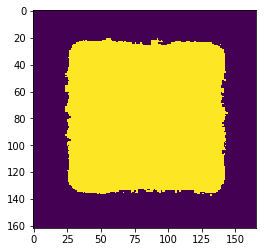

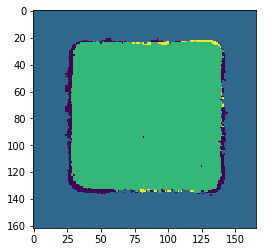

In [85]:
i = 150
plt.imshow(binarize(tmp[i], 3))
plt.show()
plt.imshow(binarize(high_transformed[i],3))
plt.show()
plt.imshow((-10*binarize(high_transformed[i],3) + 20*binarize(tmp[i], 3)))#&binarize(high_transformed[100],3))

In [90]:
dump(tmp_dark, 'files/low_transformed_dark.np')

['files/low_transformed_dark.np']

In [96]:
from mpl_toolkits.mplot3d import Axes3D

In [97]:
points = binarize(low_transformed, 3)

In [99]:
pionts_ = points==points[tuple(i//2 for i in points.shape)]

In [111]:
non_zero= np.where(points)
choice = np.random.rand(len(non_zero[0])) < .01
X, Y, Z = [x[choice] for x in non_zero]

In [112]:
X.shape

(17078,)

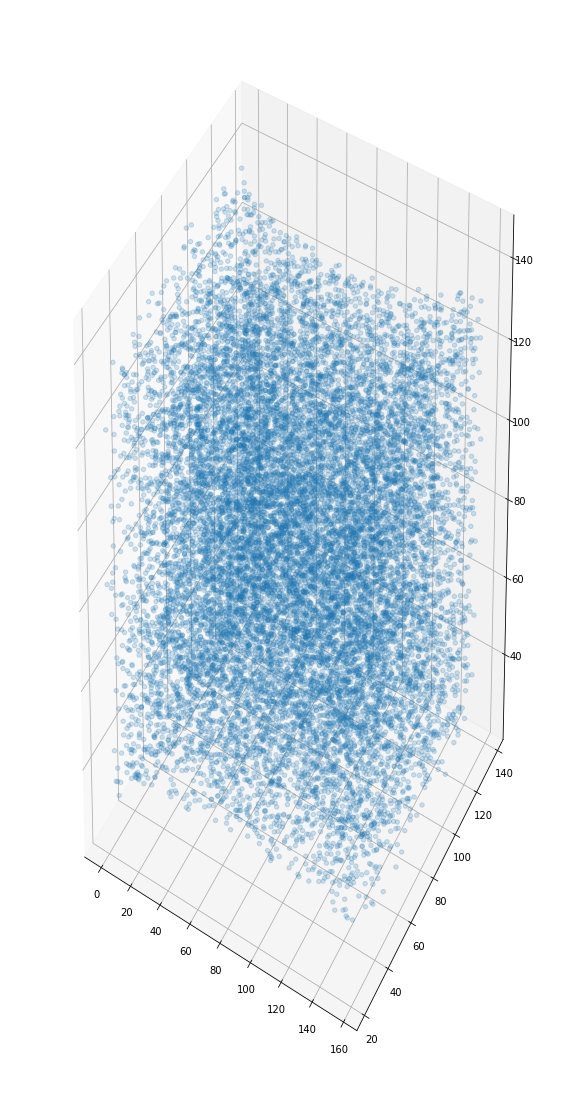

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, alpha=.2)

(512, 512)
(256, 256)


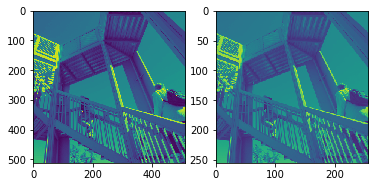

In [76]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, .50)
ax1.imshow(ascent)
ax2.imshow(result)
print(ascent.shape)
print(result.shape)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, 3.0)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

In [7]:
scipy.__version__

'1.4.1'

In [178]:
res

NameError: name 'res' is not defined

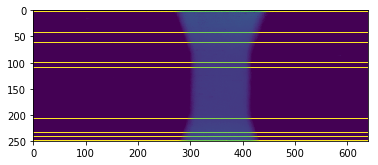

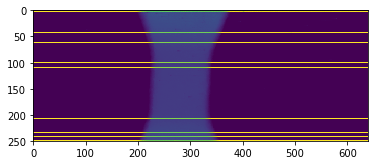

In [71]:
tmp = np.array([_ for _ in low_bin_3d['absorption']])#[:,200:400,200:350]
plt.imshow(tmp.mean(axis=2)), plt.show()
plt.imshow(tmp.mean(axis=1))

In [21]:
#bin_high_1, bin_high_2 = binarize(high_side1), binarize(high_side2)
#TODO: binarize
bin_low_1, bin_low_2 = binarize(low_side1), binarize(low_side2)

NameError: name 'low_side1' is not defined

In [22]:
low_indices = 70, -49

In [23]:
high_indices = 175, -175

In [24]:
(997-175-175)/(210-70)

4.621428571428571

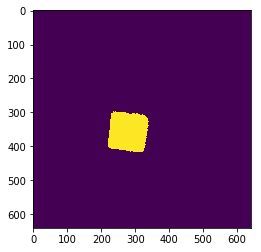

In [37]:
plt.imshow(area1['absorption'][200])

In [33]:
hl1, hl2

(627.5692277859175, 623.2715981888782)

In [35]:
ll1, ll2

(108.73300573300574, 105.36620209059234)

In [36]:
hl1/hl2

1.0068952758468819

In [37]:
ll1/ll2

1.0319533548292712

array([221, 222, 223, ..., 330, 331, 332])

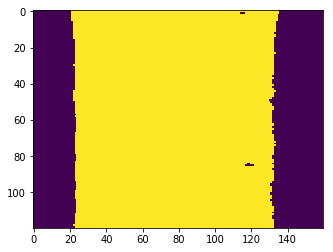

In [38]:
plt.imshow(lside1[:,200:360])
np.where(lside1)[1]

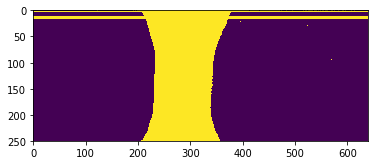

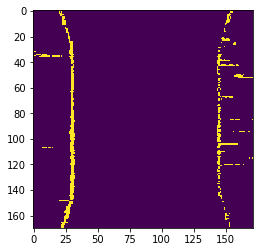

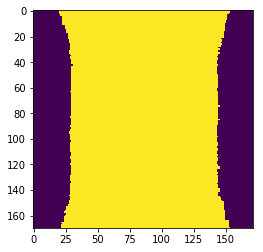

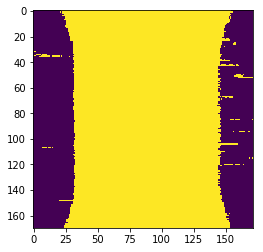

In [90]:
def _(h_side, l_side, widths, ws, hs):
    h_width, l_width = widths
    new_shape = tuple(int(np.round(x*l_width/h_width, 1)) for x in h_side.shape)
    h_resized = cv2.resize(h_side*255, new_shape)>0
    h, w = h_resized.shape
    l_side = l_side[hs:hs+h,ws:ws+w]>0
    if l_side.shape == h_resized.shape:
        plt.imshow(min_max_scale(l_side) != min_max_scale(h_resized))
        plt.show()
        plt.imshow((h_resized)) 
        plt.show()
        plt.imshow((l_side)) 
        plt.show()
    else:
        print("Sizes don't match")
_(high_side1, low_side1, (hl1, ll1), 190, 55)
#_(high_side2, rotate_image(low_side2, 2), (hl2, ll2), 200, 55)
#_(high_side1, rotate_image(low_side2, 2), hl2, ll2, 200, 55)

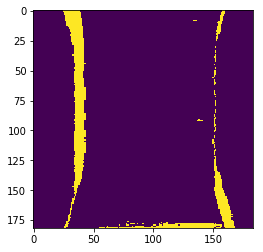

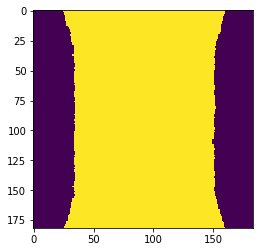

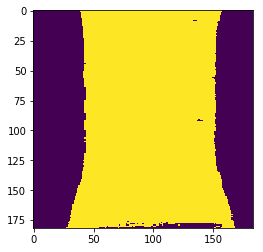

In [276]:
_(bin_high_1, bin_low_1, (hl, ll), x, 68)

In [247]:
bin_high_1, bin_low_1, (hl, ll), x, y = list(ins)[np.argmin(abbas)]

In [305]:
align((bin_high_1, bin_low_1, (hl, ll), x, y) )

(182, 184) (181, 184)


inf

In [268]:
hl, ll, x, y

(613.2715981888782, 113.36620209059234, 180, 69)

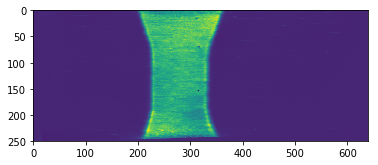

In [246]:
plt.imshow(rotate_image(low_side2, 2))

In [89]:
new_shape = tuple(int(np.round(x*ll1/hl1, 1)) for x in high_side1.shape)
new_shape

(172, 171)

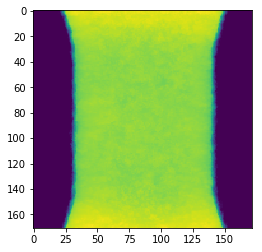

In [96]:
h_resized = cv2.resize(high_side1, new_shape)
plt.imshow(h_resized)

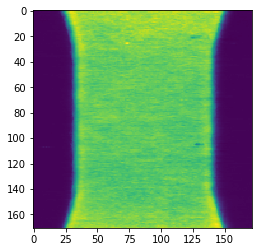

In [124]:
h, w = h_resized.shape
ws = 190
hs = 55
plt.imshow(min_max_scale(low_side1[hs:hs+h,ws:ws+w])+min_max_scale(h_resized))

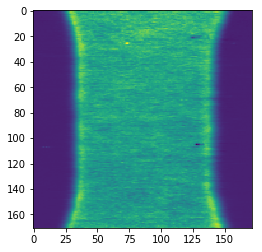

In [125]:
plt.imshow(min_max_scale(low_side1[hs:hs+h,ws:ws+w]))

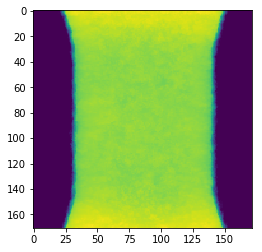

In [126]:
plt.imshow(min_max_scale(h_resized))

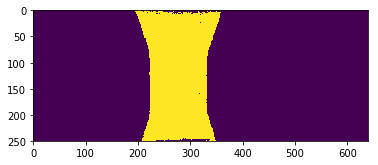

In [179]:
plt.imshow(binarize(low_side1))

In [51]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
 
class StridedNet:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
 
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

Using TensorFlow backend.


ImportError: cannot import name 'abs'